# First Tests and Exploration

In [1]:
## Imports
# import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable
from scipy.optimize import approx_fprime

In [2]:
## Definition of test functions
def f(x: np.ndarray) -> float:
    if type(x) == list: x = np.array(x)
    return(np.linalg.norm(x)**8.)

def grad_f(x: np.ndarray) -> np.ndarray:
    if type(x) == list: x = np.array(x)
    return(8*x*np.linalg.norm(x)**6.)

In [3]:
np.allclose(f([1, 2]), 5**4)

True

In [4]:
class HamiltonianDescent:

    kinetic_energy_choices: list[str] = ["square", "relativistic"]
    kinetic_energy: str 
    finite_elements_diff: bool
    numeric_diff_epsilon: float
    epsilon: float
    gamma: float
    convergence_tolerance: float
    max_iterations: int

    def __init__(
        self, 
        kinetic_energy: str = "square", 
        finite_elements_diff: bool=True, 
        epsilon: float=1e-5, 
        gamma: float=1e5, 
        convergence_tolerance: float=1e-5,
        max_iterations: int=1000,
        numeric_diff_epsilon: float=None
    ):
        if kinetic_energy not in self.kinetic_energy_choices: raise ValueError(f"The kinetic_energy attribute must be in {self.kinetic_energy_choices}")
        self.kinetic_energy = kinetic_energy
        self.numeric_diff_epsilon = numeric_diff_epsilon
        self.epsilon = epsilon
        self.gamma = gamma
        self.convergence_tolerance = convergence_tolerance
        self.finite_elements_diff = finite_elements_diff
        self.max_iterations = max_iterations

    ## Providing numeric gradient from scipy if no analytical gradient is known.
    def numeric_diff(self, x: np.ndarray, f: Callable[[np.ndarray], float]) -> np.ndarray:
        grad_func = approx_fprime(x, f, epsilon=self.numeric_diff_epsilon)
        return(grad_func)

    def grad_square(self, p: np.ndarray) -> np.ndarray:
        if type(p) == list: p = np.array(p)
        return(np.array(p))
        
    def grad_relativ(self, p: np.ndarray) -> np.ndarray:
        if type(p) == list: p = np.array(p)
        return(np.array(p) / np.sqrt(np.linalg.norm(p)**2 + 1.))

    def update(
        self,
        x: np.ndarray, 
        p: np.ndarray, 
        f: Callable[[np.ndarray], float]=None,
        grad_f: Callable[[np.ndarray], np.ndarray]=None,
    ) -> tuple[np.ndarray, np.ndarray]:

        if type(p) == list: p = np.array(p)
        if type(x) == list: x = np.array(x)
        
        delta = 1. / (1.+self.gamma*self.epsilon)

        ## Updates
        if not self.finite_elements_diff:
            pp = delta*p - self.epsilon*delta * grad_f(x)
        if self.finite_elements_diff:
            pp = delta*p - self.epsilon*delta * self.numeric_diff(x, f)
        if self.kinetic_energy == "square":
            xx = x + self.epsilon * self.grad_square(p)
        if self.kinetic_energy == "relativistic":
            xx = x + self.epsilon * self.grad_relativ(p)

        return(pp, xx)

    ## Full algorithm
    def optimize(
        self,
        f: Callable[[np.ndarray], float],
        grad_f: Callable[[np.ndarray], np.ndarray]=None,
        dim: int=2,
        x0: np.ndarray = None,
        p0: np.ndarray = None,
    ) -> dict[np.ndarray, np.ndarray, float, np.ndarray, np.ndarray]:
        
        if x0 == None: x = np.random.uniform(size=dim) 
        else: x = x0
        if p0 == None: p = np.random.uniform(size=dim)
        else: p = p0

        ## First iteration
        f_history = np.array(f(x))
        x_history = np.array(x)
        p_history = np.array(p)

        ## Following iterations
        i = 0
        while i < self.max_iterations: # and np.abs(f_history[-1] - f_history[-2]) > self.convergence_tolerance
            x, p = self.update(x, p, f, grad_f)
            f_history = np.hstack((f_history, f(x)))
            x_history = np.vstack((x_history, x))
            p_history = np.vstack((p_history, p))
            i += 1

        return_dict = {
            'x_star': x,
            'p_star': p,
            'f_min': f_history[-1],
            'f_history': f_history,
            'x_history': x_history,
            'p_history': p_history
        }

        return return_dict


    

In [5]:
f_dim = 2

In [6]:
## Searching for a good gamma-value when dimensionality is given:
print(f"{10.**(f_dim):.2E}")

1.00E+02


In [7]:
test = HamiltonianDescent(kinetic_energy="relativistic", gamma=1e5, max_iterations=30)

In [8]:
np.allclose(test.numeric_diff(x=[1, 1], f=f), grad_f([1, 1]))

True

In [9]:
result = test.optimize(f, dim=f_dim)
print(result['x_star'][:5])
print(result['f_min'])

[3.04722373e-05 2.27099309e-05]
4.351384777630224e-36


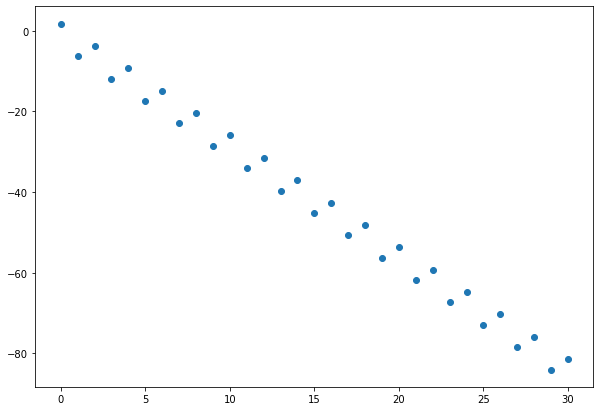

In [10]:
relevant_f_vals = result['f_history'][result['f_history'] > 0]
it = np.arange(0, len(relevant_f_vals))

plt.figure(figsize=(10, 7))
plt.scatter(it, np.log(relevant_f_vals)) 
plt.show()

#### Following only make sense for $f: \R^{2} \to \R$, i. e. $x \in \R^{2}$

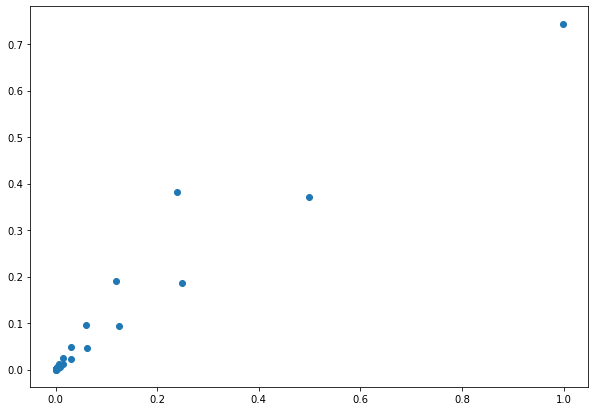

In [11]:
plt.figure(figsize=(10, 7))
plt.scatter(result['x_history'][:, 0], result['x_history'][:, 1])
plt.show()

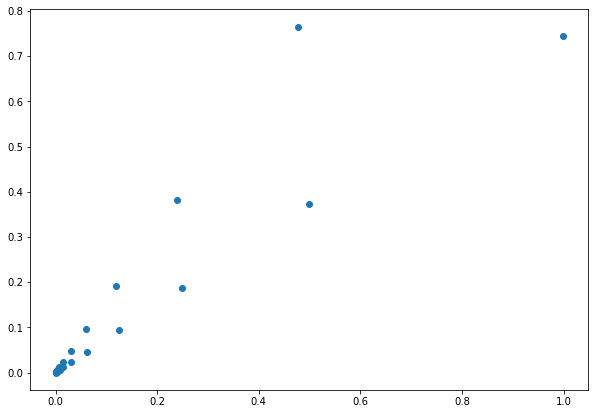

In [12]:
plt.figure(figsize=(10, 7))
plt.scatter(result['p_history'][:, 0], result['p_history'][:, 1])
plt.show()